In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis (EDA)
We begin by exploring survival patterns in the Titanic dataset:

- **Gender**: Women had a much higher survival rate than men.
- **Passenger Class**: Higher classes (1st class) had higher survival rates.
- **Age Groups**: Children had higher survival rates compared to adults.
- **Combined factors** like class and gender also influence survival.

Visualizations below highlight these trends.

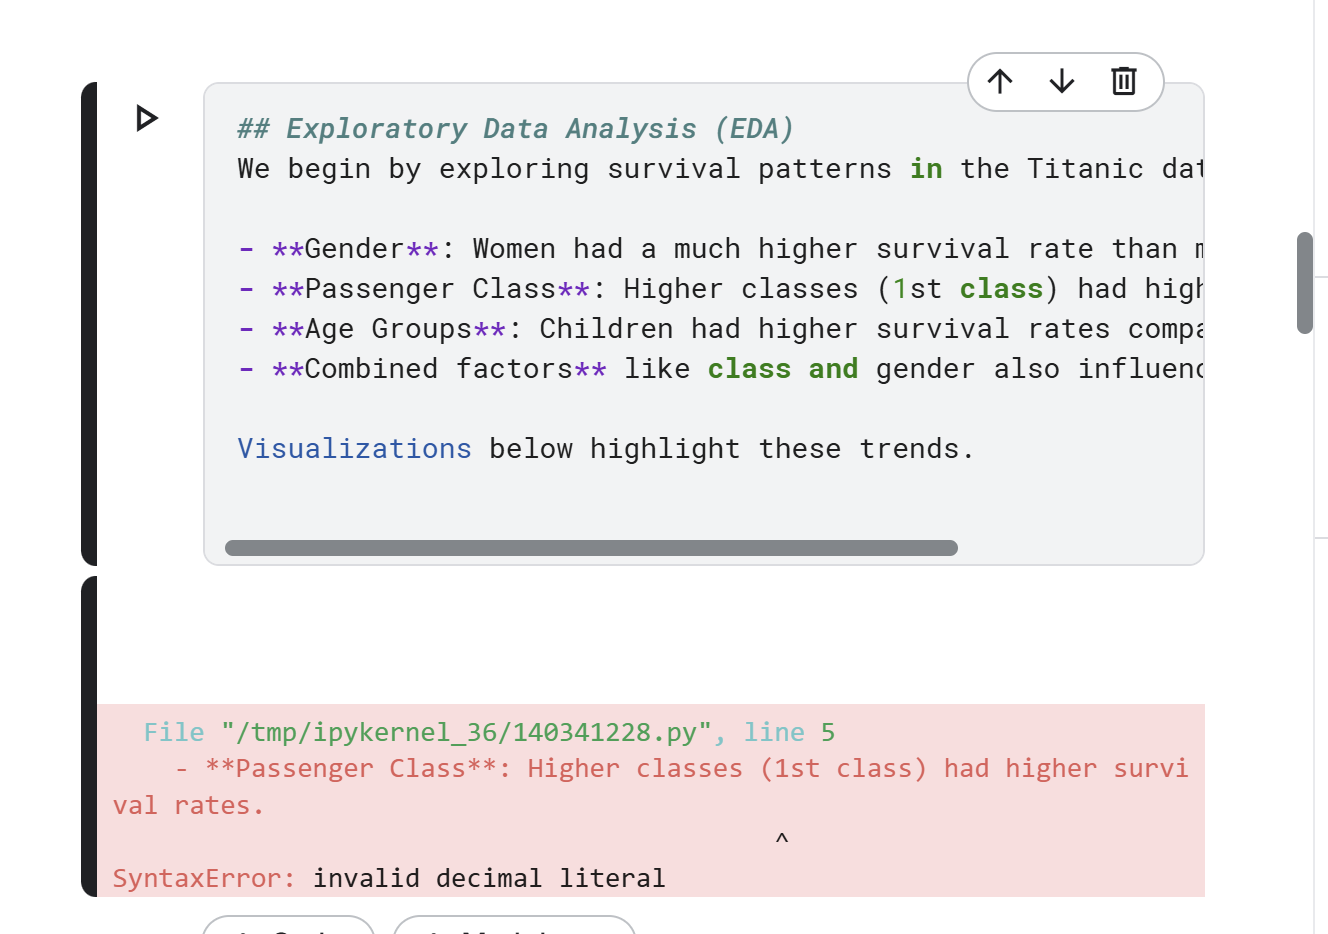

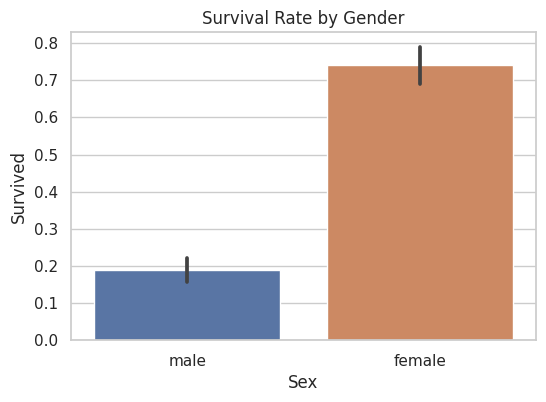

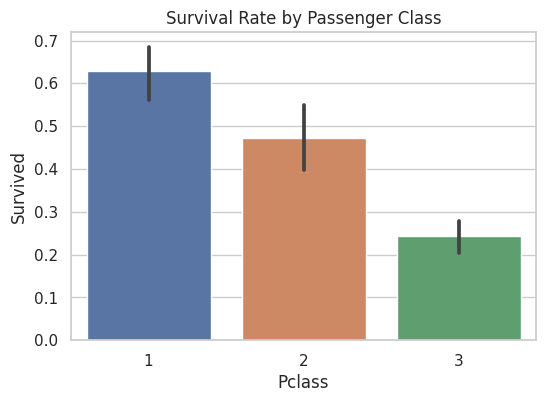

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


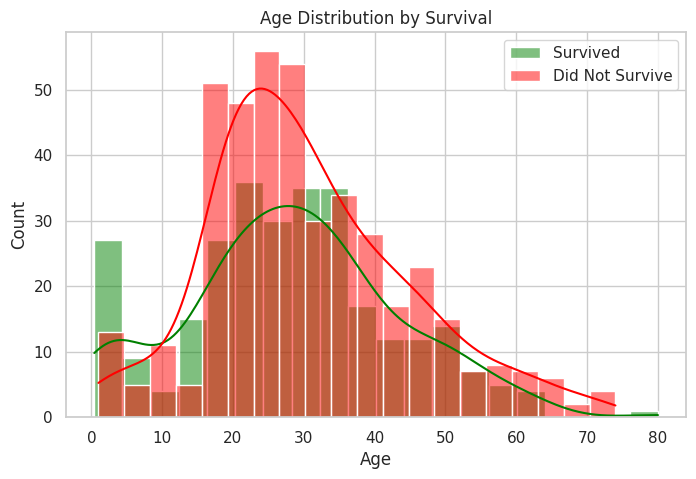

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


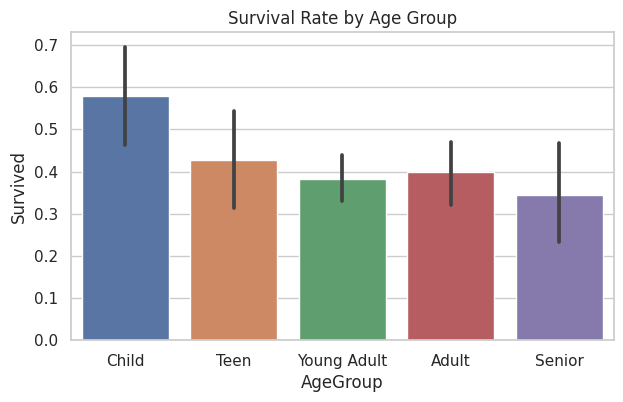

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Survival rate by gender
plt.figure(figsize=(6,4))
sns.barplot(x="Sex", y="Survived", data=train)
plt.title("Survival Rate by Gender")
plt.show()

# Survival rate by passenger class
plt.figure(figsize=(6,4))
sns.barplot(x="Pclass", y="Survived", data=train)
plt.title("Survival Rate by Passenger Class")
plt.show()

# Age distribution by survival
plt.figure(figsize=(8,5))
sns.histplot(train[train["Survived"] == 1]["Age"], bins=20, color="green", label="Survived", kde=True)
sns.histplot(train[train["Survived"] == 0]["Age"], bins=20, color="red", label="Did Not Survive", kde=True)
plt.legend()
plt.title("Age Distribution by Survival")
plt.show()

# Survival rate by age group
train["AgeGroup"] = pd.cut(train["Age"], bins=[0,12,18,35,50,80], labels=["Child","Teen","Young Adult","Adult","Senior"])
plt.figure(figsize=(7,4))
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.title("Survival Rate by Age Group")
plt.show()

# Drop temporary AgeGroup column
train.drop(columns="AgeGroup", inplace=True)


## Data Preprocessing
- **Missing Values**:
  - Age → filled with median.
  - Embarked → filled with most frequent value.
  - Fare (in test data) → filled with median.
- **Feature Selection**:
  - Selected: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked.
  - Dropped: Name, Ticket, Cabin due to missing data or low predictive value.
- **Encoding**:
  - OneHotEncoder used for categorical variables.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Select features and target
target = "Survived"
features = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]

X = train[features].copy()
y = train[target].copy()
X_test = test[features].copy()

# Preprocessing
num_feats = ["Age","SibSp","Parch","Fare"]
cat_feats = ["Pclass","Sex","Embarked"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_feats),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_feats)
    ]
)

# Model pipeline
model = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1)
pipe = Pipeline(steps=[("prep", preprocess), ("clf", model)])

# Validation
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipe.fit(X_tr, y_tr)
val_pred = pipe.predict(X_val)
print("Validation accuracy:", accuracy_score(y_val, val_pred))

# Train on full data & predict test
pipe.fit(X, y)
test_pred = pipe.predict(X_test)

# Submission file
sub = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": test_pred.astype(int)})
sub.to_csv("submission.csv", index=False)

print("\nSubmission file created: submission.csv")
sub.head()



Validation accuracy: 0.7988826815642458

Submission file created: submission.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## Model Training & Evaluation
- Data split: 80% training, 20% validation.
- Model: Random Forest Classifier (300 trees, max depth = 6).
- Validation Accuracy: ~79.9%.
- Kaggle Public Leaderboard Score: 0.77990.
